# IMPORT LIBRARIES

In this section we import the necessary libraries for the realization of our classification

In [123]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from shapely.geometry import mapping
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import geopandas as gpd
import numpy as np
import lithops
import pandas
import pickle
import joblib
import time
import glob
import os
print("Done")

Done


### 1. From here, we create a stack of the bands to use

In [76]:
#directory input and local output
input_directory= '/home/jovyan/imagenes'
#we create a search criteria for the files to use
criteria =  "B*.tif"
#we create a search criteria variable called'p'
p = os.path.join(input_directory, criteria)

In [77]:
#having a search criteria we can remember our folder and have a variable with search criteria
list_files  =  glob.glob(p)
#verificate
print(list_files)
print("Done")

['/home/jovyan/work/Finales-Serverless/organizados/imagenes/B3.tif', '/home/jovyan/work/Finales-Serverless/organizados/imagenes/B4.tif', '/home/jovyan/work/Finales-Serverless/organizados/imagenes/B8.tif']
Done


In [78]:
#the metadata of the first file is read to take it as an information base
with rasterio.open(list_files[0]) as src0:
    meta = src0.meta
    
#update metadata  
meta.update(count = len(list_files))
#we create an exit route
img_dir_exit = '/home/jovyan/Output'
   
img_stack = img_dir_exit + 'list_files.tif'
print("Done")

Done


In [79]:
#stack the files
with rasterio.open(img_stack, 'w', **meta) as dst:
    for id, layer in enumerate(list_files, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
print("Done")

Done


In [80]:
#check the number of bands the dimensions
full_data = rasterio.open(img_stack)
img_rows, img_cols = full_data.shape
img_bands = full_data.count
#print 
print(full_data.shape)
print(full_data.count)

(10980, 10980)
3


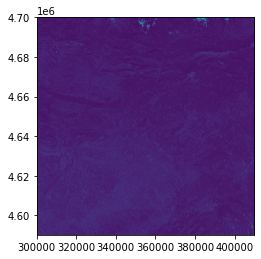

<Figure size 432x288 with 0 Axes>

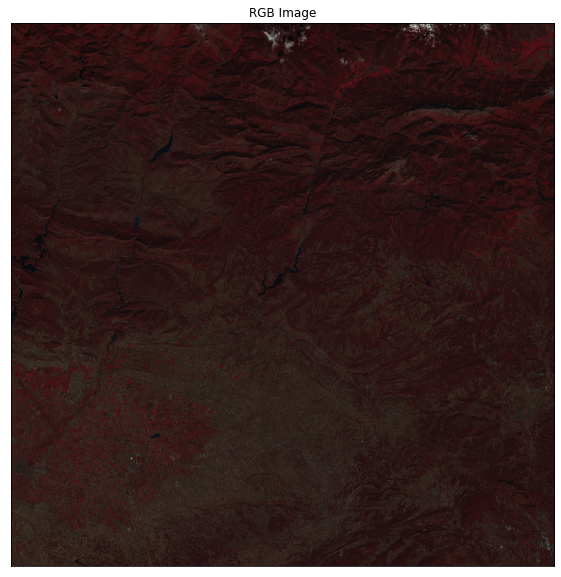

Done


In [36]:
#show stacked image
show(full_data)
#show stacked image in RGB
arr_st, meta = es.stack(list_files, nodata=-9999)
# fig, ax = plt.subplots(figsize=(12, 12))
# Plot red, green, and blue bands, respectively
plt.figure()
ep.plot_rgb(arr_st, rgb=(2, 1, 0),title="RGB Image")
# plt.show()

print("Done")

### 2. Now the goal is obtain the pixels of the training areas

In [81]:
#with geopanda we can read and explore our shapefile
train_areas=gpd.read_file('/home/jovyan/entrenamiento/ENTRENAELVIS.shp')
print(train_areas.crs)
print(train_areas.shape)

#if it does not have the same coordinate system of the dataset use to_crs and use the correct epsg
print("Done")

None
(26, 6)
Done


In [82]:
#Now we generate a list of geometries
geoms=train_areas.geometry.values

#we select a feature of the geometry to verify
geometry=geoms[0]
print(type(geometry))
print("Done")

<class 'shapely.geometry.polygon.Polygon'>
Done


In [83]:
#transform to format gjson and verificate
from shapely.geometry import mapping
feature = [mapping(geometry)]
print(type(feature))
print (feature)
print("Done")

<class 'list'>
[{'type': 'Polygon', 'coordinates': (((354081.87260000035, 4648627.0021), (354576.96829999983, 4648524.2464000005), (354203.31120000035, 4647795.615), (353596.1183000002, 4647244.4706999995), (353315.8755000001, 4647496.689300001), (353680.19120000023, 4648010.467800001), (354081.87260000035, 4648627.0021)),)}]
Done


In [84]:
#the raster values are extracted within the training areas
out_img_extr, out_transform = mask(full_data, feature, crop=True)
out_img_extr.shape 
print("Done")

Done


### 3. Build the training for the classifier

In [87]:
#Build the training for the classifier
X = np.array([], dtype=np.int8).reshape(0,3) # pixels
y = np.array([], dtype=np.string_) # labels
print("Done")

Done


In [88]:
# extract the value of our raster within the training polygons
with rasterio.open(img_stack) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]
        #mask return pixel in to array 
        out_img_extr, out_transform = mask(src, feature, crop=True)
        # remove all pixels with 0 values 
        out_img_extr_trimmed = out_img_extr[:,~np.all(out_img_extr == 0, axis=0)]
        # remove all pixels with 255 values
        out_img_extr_trimmed = out_img_extr_trimmed[:,~np.all(out_img_extr_trimmed == 255, axis=0)]
        # reshape the array [recuento de píxeles, bandas] 
        out_img_extr_reshaped = out_img_extr_trimmed.reshape(-1, band_count)
        # add the labels to array 
        y = np.append(y,[train_areas["clases"][index]] * out_img_extr_reshaped.shape[0])
        # stack the pixels to array
        X = np.vstack((X,out_img_extr_reshaped))
print("Done")

Done


In [89]:
#Checking labels
labels = np.unique(train_areas["clases"])
print('Los campos contienen {n} clases y son los siguientes: {clases}\n'.format(n=labels.size,clases=labels))
print('{sz}'.format(sz=X.shape))
print('{sz}'.format(sz=y.shape))
print("Done")

Los campos contienen 4 clases y son los siguientes: ['agua' 'bosque' 'cultivos' 'urbano']

(83697, 3)
(83697,)
Done


### 4.Train the model and prediction


we already have the reflectances, matrix and labels

In [90]:
#train the model #TODO: Apply crossvalidation
gnb = GaussianNB()
gnb.fit(X, y)
print("Done")

Done


##### Prediction 

In [91]:
# We create a function that assigns the classes to indices and with it a dictionary that relates the classes of the indices
def str_class_to_int(class_array):
    class_array[class_array == 'agua'] = 0
    class_array[class_array == 'bosque'] = 1
    class_array[class_array == 'cultivos'] = 2
    class_array[class_array == 'urbano'] = 3
    return(class_array.astype(int))
print("Done")

Done


In [92]:
#due to the computer cost, it is necessary to view a part of the image
with rasterio.open(img_stack) as src:
    img = src.read()[:, 1500: 2000, 1500 : 2500]  #posicion    col_off, row_off, width, height 
print("Done")

Done


In [93]:
#we select the complete image and in a long 2d matrix to be able to visualize it
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)
print("Done")

(500, 1000, 3)
Done


In [104]:
#predecimos para cada pixel en nuestra imagen # TODO: for each pixel of our we perform a prediction
prediction = gnb.predict(reshaped_img.reshape(-1, 3))
#we reshape our classified image in a 2d matrix to be able to see it
prediction = prediction.reshape(reshaped_img[:, :, 0].shape)
#We use the previously performed function to convert the strings that the shapefile initially gave us into a numpy matrix
prediction = str_class_to_int(prediction)
print("Done")

Done


In [105]:
#check
print (prediction)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 2 1 1]
 [1 1 1 ... 2 2 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 0 1 ... 1 1 2]
 [1 1 1 ... 1 1 1]]


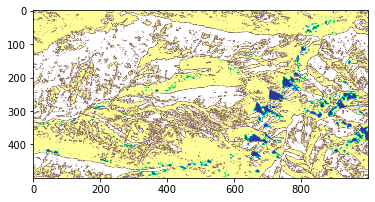

Done


In [106]:
#Show
show(prediction, cmap='terrain')
print("Done")

#### Save your array as .tif

In [107]:
#let's change the format from to int 32
# y = class_prediction.astype(np.int32) # TODO: Check this
y = prediction.astype(np.int32) 
print("Done")

Done


In [108]:
# we write the output with rasterio
SalidaR = rasterio.open('/home/jovyan/Output/rasteriop.tif','w',
                   driver='Gtiff',
                   width = 1000,
                   height = 500,
                   count=1,
                   crs = full_data.crs,  # TODO: Check this => full_dataset.crs,
                   transform = full_data.transform, # TODO: Check this => full_dataset.crs,
                   dtype='int32')
SalidaR.write(y,1)
SalidaR.close()
print("Done")

Done


# Exporting model as pickle

In [109]:
filename = 'finalized_model.sav'
model = gnb
pickle.dump(model, open('/home/jovyan/COS/' + filename, 'wb'))
print("Done")

Done


# Loading the model from pickle file

In [110]:
#load the model from disk
loaded_model = pickle.load(open('/home/jovyan/COS/' + filename, 'rb'))
# result = loaded_model.score(X, y)
# print(result)
print("Done")

Done


# Exporting and Importing Model with joblib from sklearn

In [111]:
# save the model to disk
filename2 = 'finalized_model_joblib.sav' 
joblib.dump(model, '/home/jovyan/COS/' + filename2)
 
 
# load the model from disk
loaded_model = joblib.load('/home/jovyan/COS/' + filename2) #also (filename2)
# result = loaded_model.score(X, y)
# print(result)

# Serverless Implementation

It consists of a simple execution using lithops where a trained model will be applied to a new image to extract the classes. This will escalate in several ways:
1- Applying the same model to several images in parallel, and then put them together
2- Apply different models to the same image to study which one offers the best results


Lithops v2.2.3 init for IBM Cloud Functions - Namespace: cloudbutton@uvigo.es_dev - Region: eu_gb
ExecutorID 6030c6/88 | JobID M000 - Selected Runtime: mavsonnen/jdsampe:nogdal - 2048MB 
ExecutorID 6030c6/88 | JobID M000 - Uploading function and data - Total: 1.6KiB
ExecutorID 6030c6/88 | JobID M000 - Starting function invocation: map_predictionV2() - Total: 1 activations
ExecutorID 6030c6/88 - Getting results...



ExecutorID 6030c6/88 - Cleaning temporary data


<ipython-input-91-238e54a759bf>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_array[class_array == 'agua'] = 0
<ipython-input-91-238e54a759bf>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_array[class_array == 'bosque'] = 1
<ipython-input-91-238e54a759bf>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_array[class_array == 'cultivos'] = 2
<ipython-input-91-238e54a759bf>:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  class_array[class_array == 'urbano'] = 3


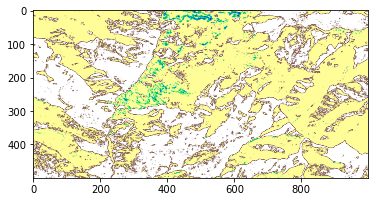

In [247]:
import warnings
warnings.filterwarnings('ignore')

config = {'ibm_cf':  {'endpoint': 'https://eu-gb.functions.cloud.ibm.com', 
                      'namespace': 'cloudbutton@uvigo.es_dev', 
                      'api_key': 'c8a9e3ec-51c9-413b-ac23-e10c3ccb71e1:k3GoGB7GRgyNFYI3ob97GAuKt8ORPYJ9eWjCfIygD0d2xeR9aowjaQlvgm7HhlPm'}, 
          'ibm_cos': {'endpoint': 'https://s3.eu-gb.cloud-object-storage.appdomain.cloud', #https://s3.eu.cloud-object-storage.appdomain.cloud 
                      'private_endpoint': 'https://s3.private.eu-gb.cloud-object-storage.appdomain.cloud',
                      'api_key' : '0GRleyXkQsvdhokMlmI0Ve-p7WxAhnKCJz9F-M7bu9qe'},
           'lithops' : {'storage_bucket' : 'bucket-gerard-eu-gb'}}

iterdata  = ['cos://bucket-gerard-eu-gb/imagenes/Corte.tif']

def map_predictionV2(obj,ibm_cos): # pasar aqui un diccionario con el modelo y la imagen
        img = src.read()#[:, 150: 200, 150 : 250]  #posicion    col_off, row_off, width, height
        reshaped_img = reshape_as_image(img)
        shapefile = ibm_cos.get_object(Bucket=obj.bucket, Key='modelos/finalized_model_joblib.sav')['Body']
        loaded_model = joblib.load(io.BytesIO(shapefile.read())) #also (filename2) => Funciona
        # For each pixel of our we perform a prediction
        prediction = loaded_model.predict(reshaped_img.reshape(-1, 3))
        #we reshape our classified image in a 2d matrix to be able to see it
        prediction = prediction.reshape(reshaped_img[:, :, 0].shape)
        #We use the previously performed function to convert the strings that the shapefile initially gave us into a numpy 
        prediction[prediction == 'agua'] = 0
        prediction[prediction == 'bosque'] = 1
        prediction[prediction == 'cultivos'] = 2
        prediction[prediction == 'urbano'] = 3
        prediction= (prediction.astype(int))
        y = prediction.astype(np.int32)

    return  prediction

def reduce_prediction(Y):
    SalidaR = rasterio.open(path + 'rasteriop.tif','w',
                       driver='Gtiff',
                       width = 1000,
                       height = 500,
                       count=1,
                       crs = full_data.crs,  # TODO: Check this => full_dataset.crs,
                       transform = full_data.transform, # TODO: Check this => full_dataset.crs,
                       dtype='int32')
    for y in Y:
        path = 'cos://bucket-gerard-eu-gb/imagenes/Output'
        SalidaR.write(y,1)
        SalidaR.close()
    return SalidaR

if __name__ == "__main__":
    fexec = lithops.FunctionExecutor(config=config,runtime='mavsonnen/jdsampe:nogdal', runtime_memory=2048)
    fexec.map(map_predictionV2, iterdata)# data_location)
    for str in results:
        prediction= np.append(prediction,str_class_to_int(str))
    show(results, cmap='terrain')
    
#     print("--- %s seconds ---" % (time.time() - start_time))